# Self-Driving Car Engineer Nanodegree

## Capstone project

### Project8: Traffic Light Classification

In [1]:
import os 
import cv2 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt
import sys 
import glob
import yaml

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers.core import Dense, Activation, Flatten, Dropout

from keras.layers import Cropping2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

tf.__version__

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array
Using TensorFlow backend.


'1.3.0'

In [2]:
# Grab test images
img_dir = "classification_images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
images = glob.glob(data_path)
classification_images = []
test_images = []

# Create the list of images to be classified
for image in images:
    classification_images.append(cv2.imread(image))
    
# Squeeze them in 1-D and convert them for the model    
for img in classification_images:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images.append(np.expand_dims(img, axis=0))

# Model path
model_path = "ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb"

# Load the Tensorflow model into memory. 
detection_graph = tf.Graph() 
with detection_graph.as_default(): 
    od_graph_def = tf.GraphDef() 
    with tf.gfile.GFile(model_path, 'rb') as fid: 
        serialized_graph = fid.read() 
        od_graph_def.ParseFromString(serialized_graph) 
        tf.import_graph_def(od_graph_def, name ='') 
  
    sess = tf.Session(graph = detection_graph) 
    
print(len(classification_images))

6


In [3]:
# Define input and output tensors (i.e. data) for the object detection classifier 
  
# Input tensor is the image 
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0') 
  
# Output tensors are the detection boxes, scores, and classes 
# Each box represents a part of the image where a particular object was detected 
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0') 
  
# Each score represents level of confidence for each of the objects. 
# The score is shown on the result image, together with the class label. 
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0') 
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0') 
  
# Number of objects detected 
num_detections = detection_graph.get_tensor_by_name('num_detections:0') 

In [4]:
# Perform the actual detection by running the model with the image as input 
images_with_boxes = []

# Detect traffic light boxes, scores for detection and classes
def detection(expand_image): 
    (boxes, scores, classes, num) = sess.run( 
        [detection_boxes, detection_scores, detection_classes, num_detections], 
        feed_dict ={image_tensor: expand_image})
    return boxes, scores, classes

# Draw boxes on image
def draw_boxes(image, boxes, scores, classes):    
    for parameter in zip(boxes[0], classes[0], scores[0]):
         if parameter[1] == 10 and parameter[2] >= .5:
            box = parameter[0]
            x_min = int(box[0] * image.shape[0])
            x_max = int(box[2] * image.shape[0])
            y_min = int(box[1] * image.shape[1])
            y_max = int(box[3] * image.shape[1])
            image = cv2.rectangle(image, (y_min,x_min),(y_max,x_max), (0,255,0), 5)
    images_with_boxes = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [5]:
boxes = []
scores = []
classes = []

for i in range (len(classification_images)):
    boxes, scores, classes = detection(test_images[i])
    images_with_boxes.append(draw_boxes(classification_images[i], boxes, scores, classes))

In [6]:
# Load train data
train_data = yaml.load(open("data_train/train.yaml"))
labels = []
train_images = []

# Cut the image looking at the boxes in the yaml
def cut_boxes(train_data):
    for train_datum in train_data:
        if len(train_datum['boxes']) != 0:
            image_path = train_datum['path']
            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_RGB2BGR)
            for box in train_datum['boxes']:
                label = box['label']
                x_min = int(box['x_min'])
                x_max = int(box['x_max'])
                y_min = int(box['y_min'])
                y_max = int(box['y_max'])
                if (x_max - x_min) > 10:
                    train_image = image[y_min:y_max,x_min:x_max,:]
                    if train_image.shape[0] != 0:
                        try:
                            train_image = cv2.resize(train_image,(14,32))
                            train_images.append(train_image)
                            labels.append(label)
                            len(labels)
                        except:
                            pass                        
cut_boxes(train_data)

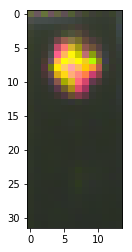

In [7]:
plt.figure()
plt.imshow(train_images[6])
plt.savefig("train_images.png")

In [8]:
# Load simulation data

# Red 
red_path = "data_train_sim/tl_data_red" # Enter Directory of all images 
data_red_sim_path = os.path.join(red_path,'*g')

images_sim_red = glob.glob(data_red_sim_path)
images_sim_red.sort()

# Green 
green_path = "data_train_sim/tl_data_green" # Enter Directory of all images 
data_green_sim_path = os.path.join(green_path,'*g')

images_sim_green = glob.glob(data_green_sim_path)
images_sim_green.sort()

# Yellow 
yellow_path = "data_train_sim/tl_data_yellow" # Enter Directory of all images 
data_yellow_sim_path = os.path.join(yellow_path,'*g')

images_sim_yellow = glob.glob(data_yellow_sim_path)
images_sim_yellow.sort()

In [9]:
print(images_sim_red[0])
print(images_sim_green[0])
print(images_sim_yellow[0])

data_train_sim/tl_data_red/traffic_lights_data_red_001.jpg
data_train_sim/tl_data_green/traffic_lights_data_green_001.jpg
data_train_sim/tl_data_yellow/traffic_lights_data_yellow_001.jpg


In [10]:
# Simulation image labeling
labels_sim = []
image_sim_paths = []

for image in images_sim_red:
    labels_sim.append('R')
    image_sim_paths.append(image)
for image in images_sim_green:
    labels_sim.append('G')
    image_sim_paths.append(image)
for image in images_sim_yellow:
    labels_sim.append('Y')
    image_sim_paths.append(image)

In [11]:
# # Shuffle simlation data (images and labels) 
# data_list = list(zip(labels_sim, image_sim_paths))
# random.shuffle(data_list)
# labels_sim, image_sim_paths = zip(*data_list)

In [12]:
# Perform traffic light detection on simulation data
classification_images_red = []
test_images_red = []
classification_images_green = []
test_images_green = []
classification_images_yellow = []
test_images_yellow = []

boxes_sim = []
classes_sim = []
scores_sim = []

sim_images_box = []
labels_sim = []
  
# RED CASE    

# Create the list of images to be classified
for image in images_sim_red:
    classification_images_red.append(cv2.imread(image))
    
# Squeeze them in 1-D and convert them for the model     
for img in classification_images_red:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images_red.append(np.expand_dims(img, axis=0))

# Cut the image looking at boxes detected
for i in range (len(images_sim_red)):
# for i in range(1):
    boxes_sim, scores_sim, classes_sim = detection(test_images_red[i])
    for parameter in zip(boxes_sim[0], classes_sim[0], scores_sim[0]):
         if parameter[1] == 10 and parameter[2] >= .5:
            box = parameter[0]
            x_min = int(box[0] * classification_images_red[i].shape[0])
            x_max = int(box[2] * classification_images_red[i].shape[0])
            y_min = int(box[1] * classification_images_red[i].shape[1])
            y_max = int(box[3] * classification_images_red[i].shape[1])
            if (x_max - x_min) > 20:
                image = classification_images_red[i][x_min:x_max,y_min:y_max,:]
                if image.shape[0] != 0:
                    try:
                        sim_image_box = cv2.resize(image,(14,32))
                        sim_image_box = cv2.cvtColor(sim_image_box, cv2.COLOR_BGR2RGB)
                        sim_images_box.append(sim_image_box)
                        labels_sim.append('R')
                    except:
                        pass
                    
# GREEN CASE    

# Create the list of images to be classified
for image in images_sim_green:
    classification_images_green.append(cv2.imread(image))
    
# Squeeze them in 1-D and convert them for the model     
for img in classification_images_green:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images_green.append(np.expand_dims(img, axis=0))

# Cut the image looking at boxes detected
for i in range (len(images_sim_green)):
# for i in range(1):
    boxes_sim, scores_sim, classes_sim = detection(test_images_green[i])
    for parameter in zip(boxes_sim[0], classes_sim[0], scores_sim[0]):
         if parameter[1] == 10 and parameter[2] >= .5:
            box = parameter[0]
            x_min = int(box[0] * classification_images_green[i].shape[0])
            x_max = int(box[2] * classification_images_green[i].shape[0])
            y_min = int(box[1] * classification_images_green[i].shape[1])
            y_max = int(box[3] * classification_images_green[i].shape[1])
            if (x_max - x_min) > 20:
                image = classification_images_green[i][x_min:x_max,y_min:y_max,:]
                if image.shape[0] != 0:
                    try:
                        sim_image_box = cv2.resize(image,(14,32))
                        sim_image_box = cv2.cvtColor(sim_image_box, cv2.COLOR_BGR2RGB)
                        sim_images_box.append(sim_image_box)
                        labels_sim.append('G')
                    except:
                        pass
                    
# YELLOW CASE    

# Create the list of images to be classified
for image in images_sim_yellow:
    classification_images_yellow.append(cv2.imread(image))
    
# Squeeze them in 1-D and convert them for the model     
for img in classification_images_yellow:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images_yellow.append(np.expand_dims(img, axis=0))

# Cut the image looking at boxes detected
for i in range (len(images_sim_yellow)):
# for i in range(1):
    boxes_sim, scores_sim, classes_sim = detection(test_images_yellow[i])
    for parameter in zip(boxes_sim[0], classes_sim[0], scores_sim[0]):
         if parameter[1] == 10 and parameter[2] >= .5:
            box = parameter[0]
            x_min = int(box[0] * classification_images_yellow[i].shape[0])
            x_max = int(box[2] * classification_images_yellow[i].shape[0])
            y_min = int(box[1] * classification_images_yellow[i].shape[1])
            y_max = int(box[3] * classification_images_yellow[i].shape[1])
            if (x_max - x_min) > 20:
                image = classification_images_yellow[i][x_min:x_max,y_min:y_max,:]
                if image.shape[0] != 0:
                    try:
                        sim_image_box = cv2.resize(image,(14,32))
                        sim_image_box = cv2.cvtColor(sim_image_box, cv2.COLOR_BGR2RGB)
                        sim_images_box.append(sim_image_box)
                        labels_sim.append('Y')
                    except:
                        pass

791
791


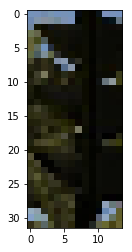

In [13]:
print(len(sim_images_box))
print(len(labels_sim))

plt.figure()
plt.imshow(sim_images_box[0])
plt.savefig("sim_images_box0.png")

In [14]:
# Label refactor: squeexe classes into the 4 we are interested in 
for i in range(len(labels)):
    if labels[i] == 'Yellow':
        labels[i] = 'Y'
    elif labels[i] == 'Red':
        labels[i] = 'R'
    elif labels[i] == 'RedLeft':
        labels[i] = 'R'
    elif labels[i] == 'RedRight':
        labels[i] = 'R'
    elif labels[i] == 'Green':
        labels[i] = 'G'
    elif labels[i] == 'GreenLeft':
        labels[i] = 'G'
    elif labels[i] == 'GreenRight':
        labels[i] = 'G'
    else:
        labels[i] = 'O'

In [15]:
# Creating a Dictionary with dict() method 
label_dict = dict({'R' : 0, 'Y' : 1, 'G' : 2, 'O' : 3}) 

# Train lists
x_real = []
y_real = []

# Use dict to store labels
y_real = [label_dict[i] for i in labels]

In [16]:
# Transform them for the model
x_real = np.array(train_images)
y_real = np.array(y_real)

In [17]:
# Train with real data

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(32,14,3)))
model.add(Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1),activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=16, kernel_size=(3, 3),strides=(1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=64, kernel_size=(3, 3) ,activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=4, activation='softmax'))
print(model.summary())


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_real,y_real,validation_split=0.2,shuffle=True,nb_epoch=16)
model.save('model_real.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 32, 14, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 12, 8)         224       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 12, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 10, 16)        1168      
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 10, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 8, 32)         4640      
_________________________________________________________________
dropout_3 (Dropout)          (None, 26, 8, 32)         0         
__________

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3244 samples, validate on 812 samples
Epoch 1/16
3244/3244 [==============================] - 4s 1ms/step - loss: 0.4384 - acc: 0.8471 - val_loss: 0.1473 - val_acc: 0.9631
Epoch 2/16
3244/3244 [==============================] - 4s 1ms/step - loss: 0.2083 - acc: 0.9340 - val_loss: 0.1451 - val_acc: 0.9557
Epoch 3/16
3244/3244 [==============================] - 4s 1ms/step - loss: 0.1827 - acc: 0.9405 - val_loss: 0.1458 - val_acc: 0.9594
Epoch 4/16
3244/3244 [==============================] - 4s 1ms/step - loss: 0.1528 - acc: 0.9498 - val_loss: 0.1423 - val_acc: 0.9667
Epoch 5/16
3244/3244 [==============================] - 4s 1ms/step - loss: 0.1407 - acc: 0.9556 - val_loss: 0.1595 - val_acc: 0.9643
Epoch 6/16
3244/3244 [==============================] - 4s 1ms/step - loss: 0.1340 - acc: 0.9556 - val_loss: 0.1127 - val_acc: 0.9729
Epoch 7/16
3244/3244 [==============================] - 4s 1ms/step - loss: 0.1345 - acc: 0.9578 - val_loss: 0.1416 - val_acc: 0.9680
Epoch 8/16
3244

In [18]:
x_sim = []
y_sim = []

# Use dict to store labels
y_sim= [label_dict[i] for i in labels_sim]

# Transform them for the model
x_sim = np.array(sim_images_box)
y_sim = np.array(y_sim)

In [19]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_sim, y_sim, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
791/791 [==============================] - 0s 263us/step
test loss, test acc: [0.22132795231532207, 0.96839443742098608]


In [20]:
# Train with simulation data

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(32,14,3)))
model.add(Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1),activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=16, kernel_size=(3, 3),strides=(1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=64, kernel_size=(3, 3) ,activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=4, activation='softmax'))
print(model.summary())


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_sim,y_sim,validation_split=0.2,shuffle=True,nb_epoch=16)
model.save('model_sim.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 32, 14, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 12, 8)         224       
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 12, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 10, 16)        1168      
_________________________________________________________________
dropout_6 (Dropout)          (None, 28, 10, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 8, 32)         4640      
_________________________________________________________________
dropout_7 (Dropout)          (None, 26, 8, 32)         0         
__________

In [21]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_real, y_real, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
4056/4056 [==============================] - 1s 230us/step
test loss, test acc: [0.64192731610886911, 0.83653846153846156]


In [22]:
# Create miscellaneous data set
x_data_set = []
y_data_set = []

x_data_set = np.concatenate((x_real, x_sim))
y_data_set = np.concatenate((y_real, y_sim))

x_data_set, y_data_set = shuffle(x_data_set, y_data_set)

x_train = []
y_train = []

x_test = []
y_test = []

# Create training and testing vars
x_train, x_test, y_train, y_test = train_test_split(x_data_set, y_data_set, test_size=0.2)

In [23]:
# Train with miscellaneous data

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(32,14,3)))
model.add(Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1),activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=16, kernel_size=(3, 3),strides=(1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=64, kernel_size=(3, 3) ,activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=4, activation='softmax'))
print(model.summary())


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train,y_train,validation_split=0.2,shuffle=True,nb_epoch=16)
model.save('model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 32, 14, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 12, 8)         224       
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 12, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 10, 16)        1168      
_________________________________________________________________
dropout_10 (Dropout)         (None, 28, 10, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 8, 32)         4640      
_________________________________________________________________
dropout_11 (Dropout)         (None, 26, 8, 32)         0         
__________

In [24]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
970/970 [==============================] - 0s 258us/step
test loss, test acc: [0.078347467838488907, 0.97628865979381441]


In [25]:
# load the model we saved
model = load_model('model.h5')
classification = model.predict_classes(x_train[0].reshape(1, 32, 14, 3), batch_size=10)

print(classification)

1/1 [==============================] - 0s 76ms/step
[2]


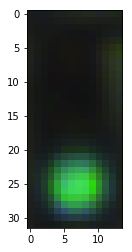

In [26]:
plt.figure()
plt.imshow(x_train[0])
plt.savefig("x_train0.png")

In [27]:
# Perform traffic light detection on udacity record data
classification_images_red = []
test_images_red = []
classification_images_green = []
test_images_green = []
classification_images_yellow = []
test_images_yellow = []
classification_images_none = []
test_images_none = []

boxes_record = []
classes_record = []
scores_record = []

record_images_box = []
labels_record = []

In [28]:
# Load record data

# Red 
red_path = "data_train_record/tl_data_red" # Enter Directory of all images 
data_red_record_path = os.path.join(red_path,'*g')

images_record_red = glob.glob(data_red_record_path)
images_record_red.sort()

# Green 
green_path = "data_train_record/tl_data_green" # Enter Directory of all images 
data_green_record_path = os.path.join(green_path,'*g')

images_record_green = glob.glob(data_green_record_path)
images_record_green.sort()

# Yellow 
yellow_path = "data_train_record/tl_data_yellow" # Enter Directory of all images 
data_yellow_record_path = os.path.join(yellow_path,'*g')

images_record_yellow = glob.glob(data_yellow_record_path)
images_record_yellow.sort()

#None

none_path = "data_train_record/tl_data_none" # Enter Directory of all images 
data_none_record_path = os.path.join(none_path,'*g')

images_record_none = glob.glob(data_none_record_path)
images_record_none.sort()

In [29]:
# RED CASE    

# Create the list of images to be classified
for image in images_record_red:
    classification_images_red.append(cv2.imread(image))
    
# Squeeze them in 1-D and convert them for the model     
for img in classification_images_red:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images_red.append(np.expand_dims(img, axis=0))

# Cut the image looking at boxes detected
for i in range (len(images_record_red)):
# for i in range(1):
    boxes_record, scores_record, classes_record = detection(test_images_red[i])
    for parameter in zip(boxes_record[0], classes_record[0], scores_record[0]):
         if parameter[1] == 10 and parameter[2] >= .5:
            box = parameter[0]
            x_min = int(box[0] * classification_images_red[i].shape[0])
            x_max = int(box[2] * classification_images_red[i].shape[0])
            y_min = int(box[1] * classification_images_red[i].shape[1])
            y_max = int(box[3] * classification_images_red[i].shape[1])
            if (x_max - x_min) > 20:
                image = classification_images_red[i][x_min:x_max,y_min:y_max,:]
                if image.shape[0] != 0:
                    try:
                        record_image_box = cv2.resize(image,(14,32))
                        record_image_box = cv2.cvtColor(record_image_box, cv2.COLOR_BGR2RGB)
                        record_images_box.append(record_image_box)
                        labels_record.append('R')
                    except:
                        pass
                    
# GREEN CASE    

# Create the list of images to be classified
for image in images_record_green:
    classification_images_green.append(cv2.imread(image))
    
# Squeeze them in 1-D and convert them for the model     
for img in classification_images_green:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images_green.append(np.expand_dims(img, axis=0))

# Cut the image looking at boxes detected
for i in range (len(images_record_green)):
# for i in range(1):
    boxes_record, scores_record, classes_record = detection(test_images_green[i])
    for parameter in zip(boxes_record[0], classes_record[0], scores_record[0]):
         if parameter[1] == 10 and parameter[2] >= .5:
            box = parameter[0]
            x_min = int(box[0] * classification_images_green[i].shape[0])
            x_max = int(box[2] * classification_images_green[i].shape[0])
            y_min = int(box[1] * classification_images_green[i].shape[1])
            y_max = int(box[3] * classification_images_green[i].shape[1])
            if (x_max - x_min) > 20:
                image = classification_images_green[i][x_min:x_max,y_min:y_max,:]
                if image.shape[0] != 0:
                    try:
                        record_image_box = cv2.resize(image,(14,32))
                        record_image_box = cv2.cvtColor(record_image_box, cv2.COLOR_BGR2RGB)
                        record_images_box.append(record_image_box)
                        labels_record.append('G')
                    except:
                        pass
                    
# YELLOW CASE    

# Create the list of images to be classified
for image in images_record_yellow:
    classification_images_yellow.append(cv2.imread(image))
    
# Squeeze them in 1-D and convert them for the model     
for img in classification_images_yellow:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images_yellow.append(np.expand_dims(img, axis=0))

# Cut the image looking at boxes detected
for i in range (len(images_record_yellow)):
# for i in range(1):
    boxes_record, scores_record, classes_record = detection(test_images_yellow[i])
    for parameter in zip(boxes_record[0], classes_record[0], scores_record[0]):
         if parameter[1] == 10 and parameter[2] >= .5:
            box = parameter[0]
            x_min = int(box[0] * classification_images_yellow[i].shape[0])
            x_max = int(box[2] * classification_images_yellow[i].shape[0])
            y_min = int(box[1] * classification_images_yellow[i].shape[1])
            y_max = int(box[3] * classification_images_yellow[i].shape[1])
            if (x_max - x_min) > 20:
                image = classification_images_yellow[i][x_min:x_max,y_min:y_max,:]
                if image.shape[0] != 0:
                    try:
                        record_image_box = cv2.resize(image,(14,32))
                        record_image_box = cv2.cvtColor(record_image_box, cv2.COLOR_BGR2RGB)
                        record_images_box.append(record_image_box)
                        labels_record.append('Y')
                    except:
                        pass
                    
# NONE CASE    

# Create the list of images to be classified
for image in images_record_none:
    classification_images_none.append(cv2.imread(image))
    
# Squeeze them in 1-D and convert them for the model     
for img in classification_images_none:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images_none.append(np.expand_dims(img, axis=0))

# Cut the image looking at boxes detected
# for i in range (len(image_record_none)):
for i in range(1):
    boxes_record, scores_record, classes_record = detection(test_images_none[i])
    for parameter in zip(boxes_record[0], classes_record[0], scores_record[0]):
         if parameter[1] == 10 and parameter[2] >= .5:
            box = parameter[0]
            x_min = int(box[0] * classification_images_none[i].shape[0])
            x_max = int(box[2] * classification_images_none[i].shape[0])
            y_min = int(box[1] * classification_images_none[i].shape[1])
            y_max = int(box[3] * classification_images_none[i].shape[1])
            if (x_max - x_min) > 20:
                image = classification_images_none[i][x_min:x_max,y_min:y_max,:]
                if image.shape[0] != 0:
                    try:
                        record_image_box = cv2.resize(image,(14,32))
                        record_image_box = cv2.cvtColor(record_image_box, cv2.COLOR_BGR2RGB)
                        record_images_box.append(record_image_box)
                        labels_record.append('O')
                    except:
                        pass

In [30]:
x_record = []
y_record = []

# Use dict to store labels
y_record = [label_dict[i] for i in labels_record]

# Transform them for the model
x_record = np.array(record_images_box)
y_record = np.array(y_record)

In [31]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on record data')
results = model.evaluate(x_record, y_record, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on record data
345/345 [==============================] - 0s 471us/step
test loss, test acc: [0.071639002319695291, 0.98260869772537895]


In [32]:
# Perform traffic light detection on new sim data
classification_images_red = []
test_images_red = []
classification_images_green = []
test_images_green = []
classification_images_yellow = []
test_images_yellow = []
classification_images_none = []
test_images_none = []

boxes_new_sim = []
classes_new_sim = []
scores_new_sim = []

new_sim_images_box = []
labels_new_sim = []

In [33]:
# Load new_sim data

# Red 

red_path = "data_train_new_sim/red" # Enter Directory of all images 
data_red_new_sim_path = os.path.join(red_path,'*g')

images_new_sim_red = glob.glob(data_red_new_sim_path)
images_new_sim_red.sort()

# Green 
green_path = "data_train_new_sim/green" # Enter Directory of all images 
data_green_new_sim_path = os.path.join(green_path,'*g')

images_new_sim_green = glob.glob(data_green_new_sim_path)
images_new_sim_green.sort()

# Yellow 
yellow_path = "data_train_new_sim/yellow" # Enter Directory of all images 
data_yellow_new_sim_path = os.path.join(yellow_path,'*g')

images_new_sim_yellow = glob.glob(data_yellow_new_sim_path)
images_new_sim_yellow.sort()

In [34]:
# RED CASE    

# Create the list of images to be classified
for image in images_new_sim_red:
    classification_images_red.append(cv2.imread(image))
    
# Squeeze them in 1-D and convert them for the model     
for img in classification_images_red:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images_red.append(np.expand_dims(img, axis=0))

# Cut the image looking at boxes detected
for i in range (len(images_new_sim_red)):
# for i in range(1):
    boxes_new_sim, scores_new_sim, classes_new_sim = detection(test_images_red[i])
    for parameter in zip(boxes_new_sim[0], classes_new_sim[0], scores_new_sim[0]):
         if parameter[1] == 10 and parameter[2] >= .5:
            box = parameter[0]
            x_min = int(box[0] * classification_images_red[i].shape[0])
            x_max = int(box[2] * classification_images_red[i].shape[0])
            y_min = int(box[1] * classification_images_red[i].shape[1])
            y_max = int(box[3] * classification_images_red[i].shape[1])
            if (x_max - x_min) > 20:
                image = classification_images_red[i][x_min:x_max,y_min:y_max,:]
                if image.shape[0] != 0:
                    try:
                        new_sim_image_box = cv2.resize(image,(14,32))
                        new_sim_image_box = cv2.cvtColor(new_sim_image_box, cv2.COLOR_BGR2RGB)
                        new_sim_images_box.append(new_sim_image_box)
                        labels_new_sim.append('R')
                    except:
                        pass
                    
# GREEN CASE    

# Create the list of images to be classified
for image in images_new_sim_green:
    classification_images_green.append(cv2.imread(image))
    
# Squeeze them in 1-D and convert them for the model     
for img in classification_images_green:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images_green.append(np.expand_dims(img, axis=0))

# Cut the image looking at boxes detected
for i in range (len(images_new_sim_green)):
# for i in range(1):
    boxes_new_sim, scores_new_sim, classes_new_sim = detection(test_images_green[i])
    for parameter in zip(boxes_new_sim[0], classes_new_sim[0], scores_new_sim[0]):
         if parameter[1] == 10 and parameter[2] >= .5:
            box = parameter[0]
            x_min = int(box[0] * classification_images_green[i].shape[0])
            x_max = int(box[2] * classification_images_green[i].shape[0])
            y_min = int(box[1] * classification_images_green[i].shape[1])
            y_max = int(box[3] * classification_images_green[i].shape[1])
            if (x_max - x_min) > 20:
                image = classification_images_green[i][x_min:x_max,y_min:y_max,:]
                if image.shape[0] != 0:
                    try:
                        new_sim_image_box = cv2.resize(image,(14,32))
                        new_sim_image_box = cv2.cvtColor(new_sim_image_box, cv2.COLOR_BGR2RGB)
                        new_sim_images_box.append(new_sim_image_box)
                        labels_new_sim.append('G')
                    except:
                        pass
                    
# YELLOW CASE    

# Create the list of images to be classified
for image in images_new_sim_yellow:
    classification_images_yellow.append(cv2.imread(image))
    
# Squeeze them in 1-D and convert them for the model     
for img in classification_images_yellow:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images_yellow.append(np.expand_dims(img, axis=0))

# Cut the image looking at boxes detected
for i in range (len(images_new_sim_yellow)):
# for i in range(1):
    boxes_new_sim, scores_new_sim, classes_new_sim = detection(test_images_yellow[i])
    for parameter in zip(boxes_new_sim[0], classes_new_sim[0], scores_new_sim[0]):
         if parameter[1] == 10 and parameter[2] >= .5:
            box = parameter[0]
            x_min = int(box[0] * classification_images_yellow[i].shape[0])
            x_max = int(box[2] * classification_images_yellow[i].shape[0])
            y_min = int(box[1] * classification_images_yellow[i].shape[1])
            y_max = int(box[3] * classification_images_yellow[i].shape[1])
            if (x_max - x_min) > 20:
                image = classification_images_yellow[i][x_min:x_max,y_min:y_max,:]
                if image.shape[0] != 0:
                    try:
                        new_sim_image_box = cv2.resize(image,(14,32))
                        new_sim_image_box = cv2.cvtColor(new_sim_image_box, cv2.COLOR_BGR2RGB)
                        new_sim_images_box.append(new_sim_image_box)
                        labels_new_sim.append('Y')
                    except:
                        pass

In [35]:
x_new_sim = []
y_new_sim = []

# Use dict to store labels
y_new_sim = [label_dict[i] for i in labels_new_sim]

# Transform them for the model
x_new_sim = np.array(new_sim_images_box)
y_new_sim = np.array(y_new_sim)

2


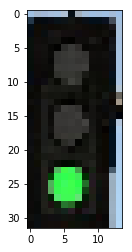

In [57]:
i = 143
plt.figure()
plt.imshow(x_new_sim[i])
print(y_new_sim[i])

In [58]:
# load the model we saved
model = load_model('model.h5')
classification = model.predict_classes(x_new_sim[i].reshape(1, 32, 14, 3), batch_size=10)

print(classification)

1/1 [==============================] - 0s 149ms/step
[2]
